You are given an excerpt of the log data from the [Swisslos](https://www.swisslos.ch) Jass servers collected between October 2017 and April 2018. In the Swiss card game [Jass](https://en.wikipedia.org/wiki/Jass), at the beginning of each round just after the cards have been dealt, the current player announces her choice of the trump mode from the options: diamonds, hearts, spades, club, obe-abe, une-ufe and push (only available when forehand). Use this information from human players to train a machine learning classifier in trump mode prediction.

In [3]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Import & Prepare Data

In [8]:
path_to_data = Path('C:\\Users\\niede\\PycharmProjects\\jass-kit-py\\')

In [9]:
# Import only a fraction of data for efficient development and testing
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None, nrows=1000)

# Import all data in the final run
# data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


In [10]:
# Display number of rows and columns
data.shape

(1000, 39)

## Rename Columns for better Interpretability

In [11]:
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


## Remove User Information

Later on you may want to keep this information. For now, we remove it just to avoid mistakes.

In [12]:
data.drop('user', axis='columns', inplace=True)
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,6
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,5
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,5
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,4


## Adjust Datatypes

In [13]:
data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
#data.dtypes

## Rename Target Category Values for better Interpretability

In [14]:
# Backward compatibility: Value 10 for PUSH was used in an older version by Swisslos

data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS',
                                  4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,False,False,False,True,True,False,True,True,False,False,...,False,True,False,False,False,True,False,False,False,PUSH
1,False,False,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,True,False,False,UNE_UFE
2,True,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,True,True,False,PUSH
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,True,False,False,False,False,UNE_UFE
4,False,True,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,False,False,True,OBE_ABE


# Data Quality Assessment

### Exercise: Sanity Check

Each row in the data now corresponds to one hand of a player plus her trump mode selection. Verify that each hand contains exactly 9 cards.

In [16]:
# Verify that each hand contains exactly 9 cards
card_counts = data[cards].sum(axis=1)

# Check if all rows have exactly 9 True values
all_nine = (card_counts == 9).all()

print("All hands contain exactly 9 cards:", all_nine)

# Optionally show rows that do not meet this condition
invalid_rows = data.loc[card_counts != 9]
print("Number of invalid hands:", len(invalid_rows))
if len(invalid_rows) > 0:
    display(invalid_rows)



All hands contain exactly 9 cards: True
Number of invalid hands: 0


### Exercise: Statistical Fingerprint

Swisslos claims to distribute cards randomly.
* Verify that all card features roughly have the same mean and standard deviation.
* Over a **large number of rounds**, we would expect similar percentages for diamonds, hearts, spades and clubs as selected Trump. Verify this claim.

Hint: you may want to use [np.allclose(...)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) in combination with an assert statement for automated checking.

#### A note on randomness - not part of exercises: 

The above test is obviously a very poor guarantee of randomness. However, we perform such tests from the viewpoint of data quality rather than fairness. If you want to challenge the random number generator of Swisslos, use the NIST or Diehard test suite for randomness. Read more about random number tests <a href='https://gerhardt.ch/random.php'>here</a>. We have not done this ourselves and keep believing that the provider of Swiss lottery use a reasonable source of randomness even for online games :-)

In [19]:
import numpy as np

# --- Check 1: Card distribution across all games ---
means = data[cards].mean()
stds = data[cards].std()

print("Mean values per card:\n", means)
print("\nStandard deviations per card:\n", stds)

# Check that all cards appear roughly equally often
# (mean and std should be close across all 36 cards)
assert np.allclose(means, means.mean(), rtol=0.1), "Card means differ too much!"
assert np.allclose(stds, stds.mean(), rtol=0.1), "Card stds differ too much!"
print("\n✅ Card distribution roughly uniform across all cards.")

# --- Check 2: Trump mode distribution ---
trump_counts = data['trump'].value_counts(normalize=True)
print("\nTrump distribution (%):\n", trump_counts * 100)

# Check that the four suits appear roughly equally often as Trump
# We ignore OBE_ABE, UNE_UFE, and PUSH for this comparison
suit_trumps = trump_counts.loc[['DIAMONDS', 'HEARTS', 'SPADES', 'CLUBS']]
assert np.allclose(suit_trumps, suit_trumps.mean(), rtol=0.2), "Trump suits are unevenly distributed!"
print("\n✅ Trump suit distribution roughly uniform across DIAMONDS, HEARTS, SPADES, and CLUBS.")


Mean values per card:
 DA     0.252
DK     0.259
DQ     0.258
DJ     0.243
D10    0.254
D9     0.231
D8     0.245
D7     0.242
D6     0.261
HA     0.242
HK     0.249
HQ     0.250
HJ     0.239
H10    0.251
H9     0.260
H8     0.256
H7     0.264
H6     0.251
SA     0.264
SK     0.238
SQ     0.270
SJ     0.248
S10    0.246
S9     0.245
S8     0.250
S7     0.257
S6     0.227
CA     0.268
CK     0.252
CQ     0.231
CJ     0.261
C10    0.258
C9     0.250
C8     0.233
C7     0.237
C6     0.258
dtype: float64

Standard deviations per card:
 DA     0.434379
DK     0.438305
DQ     0.437753
DJ     0.429110
D10    0.435515
D9     0.421683
D8     0.430302
D7     0.428509
D6     0.439400
HA     0.428509
HK     0.432650
HQ     0.433229
HJ     0.426686
H10    0.433805
H9     0.438854
H8     0.436640
H7     0.441020
H6     0.433805
SA     0.441020
SK     0.426072
SQ     0.444182
SJ     0.432068
S10    0.430894
S9     0.430302
S8     0.433229
S7     0.437198
S6     0.419102
CA     0.443139
CK     0.43437

In [ ]:
data.trump.value_counts()

Can you explain ...
* the difference between Une-Ufe and Obe-Abe ?
* the difference between {spades, clubs} and {hearts, diamonds}

The fact that the values of the response are not distributed evenly has implications on the train-test split in the next section.

# Modelling and Prediction

### Train-Test Split

Split the available data into a training and a test set and put the test set aside for the final model evaluation. Use 20% of the data for testing, and set the random_state to 42 for reproducability. Since we found out that the classes are not distributed evenly, you need to stratify. Also, be aware that train_test_split() shuffles the data by default, which is what we want here (but not always, e.g. not in case of time series).

Your result should be the four variables *X_train, X_test, y_train, y_test*.

In [21]:
from sklearn.model_selection import train_test_split

feature_columns = cards + forehand
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

## Baseline with a Logistic Regression Classifier

We create a (linear) logistic regression classifier and evaluate it with cross validation.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

classifier = LogisticRegression()

# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.5725


### Exercise: Stochastic Gradient Descent

Machine learning classifiers internally use an optimization algorithm. Stochastic gradient descent is a stochastic 
approximation that generally is more efficient but with a slightly lower convergence rate. Change the code in the previous cell to a logistic regression with stochastic gradient descent. Use [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) with parameters *loss='log'* and *penalty='None'*

In [24]:
from sklearn.linear_model import SGDClassifier

# Logistic regression trained via stochastic gradient descent
classifier = SGDClassifier(loss='log_loss', penalty=None, random_state=42)

# 5-fold cross-validation
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds with SGD is {:.4}".format(np.mean(result)))


Mean accuracy over 5 folds with SGD is 0.5463


## Learning Curves

Learning curves are an important diagnostic instrument in machine learning. A cross-validation generator splits the whole dataset k times into training and test data. Subsets of the training set with increasing sizes will be used to train the estimator and a score for each training subset size on the validation set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

As a rule of thumb, a gap between the training and validation curves indicates that using more data would improve accuracy.

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    SGDClassifier(loss='log_loss', penalty=None, random_state=42),
    X_train,
    y_train,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 50),
    cv=10,
    verbose=10
)


[learning_curve] Training set sizes: [ 72  85  98 111 124 138 151 164 177 191 204 217 230 243 257 270 283 296
 310 323 336 349 362 376 389 402 415 429 442 455 468 481 495 508 521 534
 548 561 574 587 600 614 627 640 653 667 680 693 706 720]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:    3.7s remaining:   41.4s
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:    3.9s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:    4.0s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:    4.2s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:    4.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:    4.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:    4.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:    4.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:    5.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.1s finished


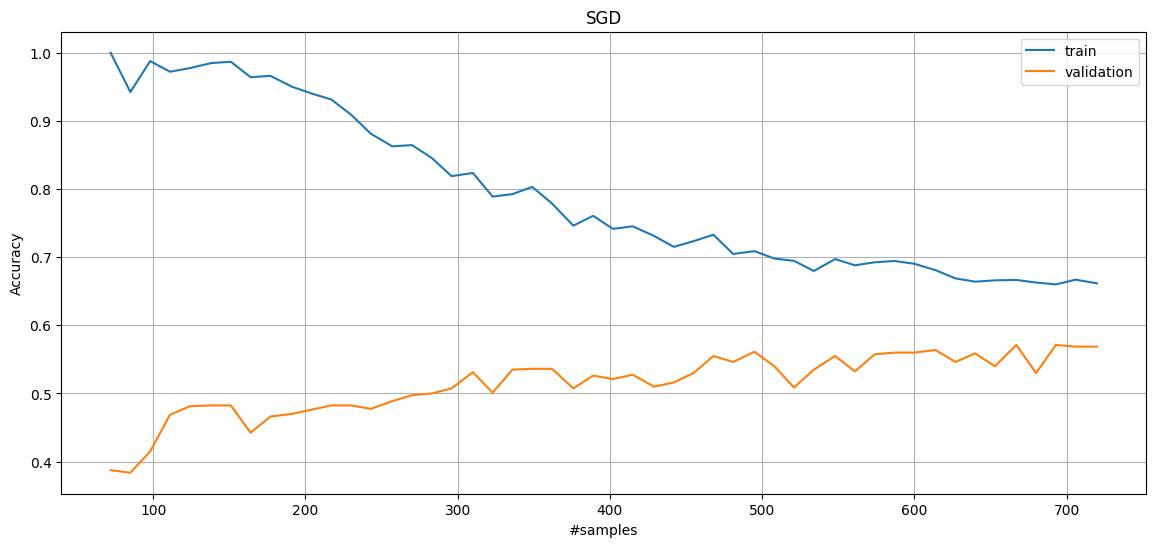

In [27]:
plot_data = pd.DataFrame({'train':train_scores.mean(axis=1), 'validation':valid_scores.mean(axis=1)}, index=train_sizes)
f, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('#samples')
ax.set_ylabel('Accuracy')
ax.set_title('SGD')
plot_data.plot(ax=ax)
plt.grid()

### Exercise: Create a Random Forest Classifier

Now create a random forest classifier and evaluate it with cross validation.

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest classifier
classifier = RandomForestClassifier(
    n_estimators=100,       # number of trees
    random_state=42,        # reproducibility
    n_jobs=-1               # use all cores
)

# 5-fold cross-validation
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds with Random Forest is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds with Random Forest is 0.5575


### Exercise: List and Plot Feature Importances

Tree classsifiers (such as decision trees and random forests) can conveniently list feature importances. They use feature values to split the training set, whereas more important features are used higher in the tree(s). Use the *feature_importances_* attribute of a trained RandomForestClassifier to obtain a sorted list of the most important features. Plot feature importances in a bar chart.

   Feature  Importance
36      FH    0.073540
30      CJ    0.037736
21      SJ    0.036147
12      HJ    0.030904
32      C9    0.030682
3       DJ    0.030391
0       DA    0.027640
23      S9    0.027533
14      H9    0.026813
8       D6    0.026502


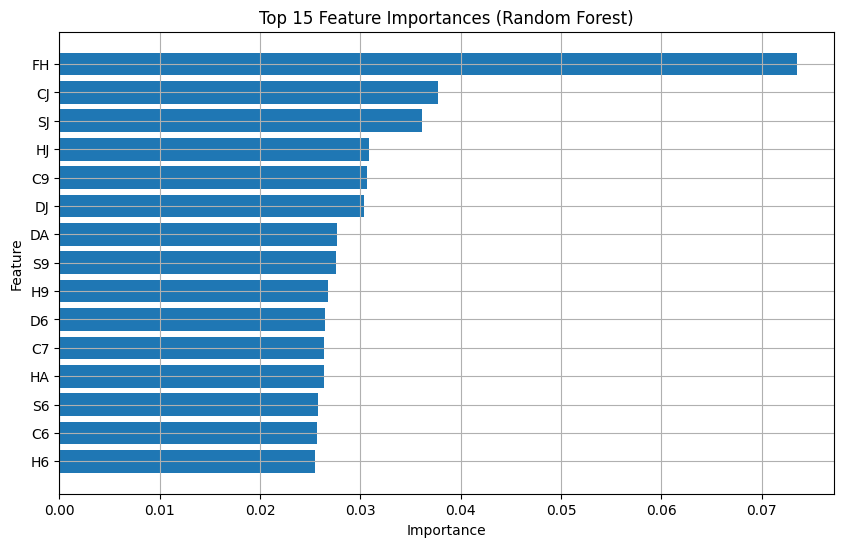

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Train the model on the full training data
classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
classifier.fit(X_train, y_train)

# Get feature importances
importances = classifier.feature_importances_
feature_names = X_train.columns

# Create a sorted DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(feat_imp.head(10))

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.grid(True)
plt.show()


## Grid Search over multiple Classifiers and Hyperparameters

In [30]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Classifier names
names = [
    "Logistic Regression",
    "Random Forest"
]

# Classifiers
classifiers = [
    LogisticRegression(solver='lbfgs', multi_class='multinomial'), # set these to avoid a FutureWarning with scikit-lean < 0.22
    RandomForestClassifier(n_estimators=200)
]

# Hyperparameter grid to search per classifier
parameters = [
    {'C': [0.5, 1.0, 2.0]},
    {'max_depth': [5, 10]}
]

list(zip(names, parameters))

[('Logistic Regression', {'C': [0.5, 1.0, 2.0]}),
 ('Random Forest', {'max_depth': [5, 10]})]

In [31]:
from sklearn.model_selection import GridSearchCV

results = []

for name, classifier, params in zip(names, classifiers, parameters):
    print("Grid search for {}".format(name))
    gs = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best accuracy score found: {:.3f}\n".format(gs.best_score_))
    results.append([name, gs.best_score_, gs.best_estimator_])

results

Grid search for Logistic Regression
Best accuracy score found: 0.589

Grid search for Random Forest


C:\Users\niede\PycharmProjects\jass-kit-py\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best accuracy score found: 0.551



[['Logistic Regression',
  np.float64(0.58875),
  LogisticRegression(C=0.5, multi_class='multinomial')],
 ['Random Forest',
  np.float64(0.55125),
  RandomForestClassifier(max_depth=10, n_estimators=200)]]

Comment: If *refit=True* (the default), the best estimator is made available at the *best_estimator_* attribute of gs and permits using *.predict()* directly on this GridSearchCV instance. Note, however, that the above code runs grid search separately for each classifier, and so gs now only contains the last estimator of the list, which may or may not be the best one. So don't use gs to predict blindly.

### Exercise: Extend Grid Search by adding other Classifiers and Hyperparameters

You may want to experiment with a [nearest neighbors classifier](http://scikit-learn.org/stable/modules/neighbors.html) or a [support vector machine](http://scikit-learn.org/stable/modules/svm.html) or a [neural network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) or ...

### Exercise: Add interactions to Logistic Regression

A linear classifier such as logistic regression cannot model dependencies between features (things like "if your hand has both heart jack and heart nine, then choose heart as trump mode"). But features like these called *interactions* can be added manually.

In [ ]:
# First, get the score without interactions
clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

For each of the four colors, add one interaction term for the combination jack and nine.

In [32]:
for color in 'DHSC':
    
    # Jack and nine combination
    new_col = '{}_J9'.format(color)
    data[new_col]  = data['{}J'.format(color)] & data['{}9'.format(color)]
    feature_columns.append(new_col)
    
    # Exercise: Add other features here such as the combination of Ace-King-Queen (Dreiblatt).
    # Ace–King–Queen combination (Dreiblatt)
    new_col = f'{color}_AKQ'
    data[new_col] = data[f'{color}A'] & data[f'{color}K'] & data[f'{color}Q']
    feature_columns.append(new_col)
    
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,FH,trump,D_J9,D_AKQ,H_J9,H_AKQ,S_J9,S_AKQ,C_J9,C_AKQ
0,False,False,False,True,True,False,True,True,False,False,...,False,PUSH,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,True,...,False,UNE_UFE,False,False,False,False,False,False,False,False
2,True,False,False,True,False,False,False,False,False,False,...,False,PUSH,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,...,False,UNE_UFE,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,True,OBE_ABE,False,False,False,True,False,False,False,False


We must recreate training and test sets with the new features

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

And check  if the additional columns improve the score

In [34]:
clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.59


### Exercise: Better Accuracy with less Data ?

At the beginning we removed the user ID from our data set. Use this information to develop a heuristic that seggregates between *good* and *bad* players. Can you improve accuracy by using only the data from *good* players?

In [43]:
data_full = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)

cards = [ # Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6' ]
# Forehand (yes = 1, no = 0)
forehand = ['FH']
user = ['user']
trump = ['trump']
data_full.columns = cards + forehand + user + trump

data_full.trump = data.trump.astype('category')
data_full[cards + forehand] = data[cards + forehand].astype(bool)
# Backward compatibility: Value 10 for PUSH was used in an older version by Swisslos
data_full.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS', 4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})

data_full = data_full.dropna(subset=['trump'])

# Convert user IDs to numeric if necessary
data_full['user'] = pd.to_numeric(data_full['user'], errors='coerce')


data_full.head()


,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,False,False,False,True,True,False,True,True,False,False,...,True,False,False,False,True,False,False,False,53248,PUSH
1,False,False,False,False,False,False,False,False,True,True,...,False,True,False,False,False,True,False,False,4613,UNE_UFE
2,True,False,False,True,False,False,False,False,False,False,...,True,False,False,False,False,True,True,False,68780,PUSH
3,False,False,False,False,False,False,False,False,False,True,...,False,False,True,True,False,False,False,False,24555,UNE_UFE
4,False,True,False,False,False,False,False,False,True,True,...,False,True,False,False,False,False,False,True,8392,OBE_ABE


In [55]:
from scipy.stats import entropy
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. Compute a consistency score for each player
player_consistency = []
for uid, df_player in data_full.groupby('user'):
    counts = df_player['trump'].value_counts(normalize=True)
    consistency = 1 - entropy(counts) / np.log(len(counts))  # 1=very consistent
    player_consistency.append((uid, consistency))
player_consistency = pd.DataFrame(player_consistency, columns=['user', 'consistency'])

# 2. Select the top 25 % most consistent (good) players
threshold = player_consistency['consistency'].quantile(0.75)
good_players = player_consistency[player_consistency['consistency'] >= threshold]['user']
data_good = data_full[data_full['user'].isin(good_players)]

# 3. Compare model accuracy
clf = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial', C=0.8)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    data_full[cards + ['FH']], data_full['trump'],
    test_size=0.2, stratify=data_full['trump'], random_state=42
)
X_train_good, X_test_good, y_train_good, y_test_good = train_test_split(
    data_good[cards + ['FH']], data_good['trump'],
    test_size=0.2, stratify=data_good['trump'], random_state=42
)

acc_all = cross_val_score(clf, X_train_all, y_train_all, cv=5, n_jobs=-1).mean()
acc_good = cross_val_score(clf, X_train_good, y_train_good, cv=5, n_jobs=-1).mean()

print(f"All players:  {acc_all:.4f}")
print(f"Good players: {acc_good:.4f}")


All players:  0.5800
Good players: 0.5582


In [52]:
user_counts = data_full['user'].value_counts()
print(user_counts.describe())
print(user_counts.head(20))


count    480.000000
mean       2.083333
std       12.877345
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      283.000000
Name: count, dtype: float64
user
0        283
57062      6
74157      5
57881      5
11123      5
60659      5
4035       5
20052      4
54641      4
70521      4
55478      4
11670      4
51453      4
68132      4
26309      4
19345      4
61101      4
65902      4
52077      4
73419      3
Name: count, dtype: int64


### Exercise: The final Score

Use the best setting you could find, train the classifier on all training data and evaluate on the yet unseen test data.

In [54]:
# Probably not the best :-)
clf = LogisticRegression(C=0.5, solver='lbfgs', multi_class='multinomial')

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

C:\Users\niede\PycharmProjects\jass-kit-py\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.59

In [56]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- 1. Logistic Regression (best setting found) ---
clf_lr = LogisticRegression(C=0.5, solver='lbfgs', multi_class='multinomial', max_iter=500, random_state=42)
clf_lr.fit(X_train, y_train)
acc_lr = accuracy_score(y_test, clf_lr.predict(X_test))

# --- 2. SGDClassifier (stochastic gradient descent logistic regression) ---
clf_sgd = SGDClassifier(loss='log_loss', penalty=None, max_iter=1000, random_state=42)
clf_sgd.fit(X_train, y_train)
acc_sgd = accuracy_score(y_test, clf_sgd.predict(X_test))

# --- 3. Random Forest ---
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
clf_rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, clf_rf.predict(X_test))

# --- Summary ---
print("Final Test Accuracy:")
print(f"Logistic Regression: {acc_lr:.4f}")
print(f"SGDClassifier:       {acc_sgd:.4f}")
print(f"Random Forest:       {acc_rf:.4f}")


C:\Users\niede\PycharmProjects\jass-kit-py\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Final Test Accuracy:
Logistic Regression: 0.5900
SGDClassifier:       0.5150
Random Forest:       0.5350


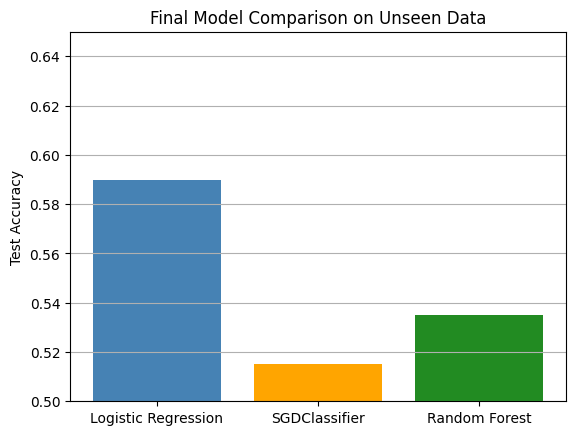

In [57]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'SGDClassifier', 'Random Forest']
scores = [acc_lr, acc_sgd, acc_rf]

plt.bar(models, scores, color=['steelblue', 'orange', 'forestgreen'])
plt.ylabel('Test Accuracy')
plt.title('Final Model Comparison on Unseen Data')
plt.ylim(0.5, 0.65)
plt.grid(axis='y')
plt.show()

In [58]:
import joblib

# assumes you already have: clf (best LogisticRegression), feature_columns
joblib.dump(
    {"model": clf_lr, "feature_columns": feature_columns},
    "jass/agents/trump_model.joblib"
)


['trump_model.joblib']